In [1]:
import pandas as pd
import numpy as np
import datetime as dt
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
# import sys
from sklearn import preprocessing as p
import warnings; warnings.simplefilter('ignore')
from tqdm import tqdm_notebook

In [2]:
#functions required to run kmeans algorithim on data

#Perform elbow method to find optimal value for K
#Define Kmeans fit
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE (average distance to centroid) for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score

#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [14]:
#import data
all_data=pd.read_csv('./Data_Output/all_data.csv')

In [15]:
#subset Single Game Buyers
all_data_singleTicket=all_data[all_data['ticket_type']=='Single Games']

In [16]:
all_data_singleTicket.shape

(2031023, 37)

In [17]:
#convert game_date and purchase_date to datetime objects
all_data_singleTicket['game_date']=pd.to_datetime(all_data_singleTicket['game_date']).dt.date
all_data_singleTicket['purchase_date']=pd.to_datetime(all_data_singleTicket['purchase_date']).dt.date

In [18]:
#get a column for delta between game_date and purchase_date
all_data_singleTicket['purchase_date_delta']=all_data_singleTicket['game_date']-all_data_singleTicket['purchase_date']

In [19]:
all_data_singleTicket['purchase_date_delta'] = all_data_singleTicket['purchase_date_delta'].dt.days.astype('int')

In [20]:
last_game_attended=all_data_singleTicket[['ticket_scanned', 'game_date', 'acct_id']][all_data_singleTicket['ticket_scanned']==1]

#group by acct_id and get the last date attended by each customer
agg_dict={'game_date': np.max}

column_names={'game_date': 'last_game_attended'}

last_game_attended=last_game_attended.groupby(['acct_id']).agg(agg_dict).rename(columns=column_names)
last_game_attended.reset_index(drop=False, inplace=True)
last_game_attended.tail()

,acct_id,last_game_attended
351029,20052733.0,2019-08-31
351030,20052760.0,2019-08-31
351031,20052853.0,2019-08-31
351032,20052906.0,2019-08-31
351033,20053106.0,2019-08-31


In [21]:
print(all_data_singleTicket.shape)
print(last_game_attended.shape)

all_data_singleTicket=all_data_singleTicket.merge(last_game_attended, on='acct_id', how='left')
print(all_data_singleTicket.shape)

(2031023, 37)
(351034, 2)
(2031023, 38)


In [23]:
#group by acct_id and determine number of tickets purchased for each acct_id and their latest purchased date
agg_dict={'last_game_attended': np.max,
          'ticket_type': np.size}

column_names={'ticket_type': 'total_tickets_bought'}

df_grouped=all_data_singleTicket.groupby(['acct_id']).agg(agg_dict).rename(columns=column_names)


In [26]:
#if an acct_id has purchased a ticket but never attended (scanned ticket) a game, they have null entries
#I fill null entries with a day before the earliest game in the dateset (04/11/2017) (time delta of 872 days) 
#to ensure that they receive the worst recency score relative to the other customers in the dataset who have 
#attended more recently
df_grouped['last_game_attended']=df_grouped['last_game_attended'].fillna(dt.date(2017, 4, 10))

In [27]:
#create another dataframe grouped by section_desc (100, 200, 500) and acct_id, and determine how many 100, 200, and 500 level tickets each acct_id purchased
df_grouped2=all_data_singleTicket.groupby(['acct_id', 'section_desc']).agg({'ticket_type':np.size}).rename(columns={'ticket_type':'total_tickets_bought'}).unstack().fillna(0)


In [28]:
#remove acct_id=0 and -1 (as they are not real account ids)
df_grouped=df_grouped[(df_grouped.index!=-1) & (df_grouped.index!=0)]
df_grouped2=df_grouped2[(df_grouped2.index!=-1) & (df_grouped2.index!=0)]

In [29]:
#Calculate Recency = the time delta between the last date on the dataframe (Aug 31, 2019) - the last date the given acct_id went to a game
df_grouped['Recency']=df_grouped['last_game_attended'].max()-df_grouped['last_game_attended']

In [30]:
#Using following prices for 100, 200, 500 level site:
#500 level=$19
#200 level=$43
#100 level=$65

#Calculate Monetary for each acct_id by multiplying the prices above by how many tickets of each section a given acct_id purchased
df_grouped2['Monetary']=df_grouped2['total_tickets_bought'][500]*19+df_grouped2['total_tickets_bought'][200]*43+df_grouped2['total_tickets_bought'][100]*65
df_M=df_grouped2['Monetary']

In [31]:
#Join dataframes to get single dataframe for RFM for each acct_id
df_RFM=df_grouped.join(df_M, how='outer')
del df_RFM['last_game_attended']

In [32]:
#rename column and display
df_RFM.rename(columns={'total_tickets_bought': 'Frequency'}, inplace=True)
#convert Recency to int
df_RFM['Recency'] = df_RFM['Recency'].dt.days.astype('int')
#remove acct_id as index, move to df
df_RFM.reset_index(drop=False, inplace=True)

In [33]:
df_RFM.head()

,acct_id,Frequency,Recency,Monetary
0,2.0,10,873,536.0
1,24.0,3,873,195.0
2,57.0,4,873,260.0
3,75.0,21,23,1365.0
4,82.0,3,784,195.0


# Recency

Text(0, 0.5, 'Number of Tickets Purchased')

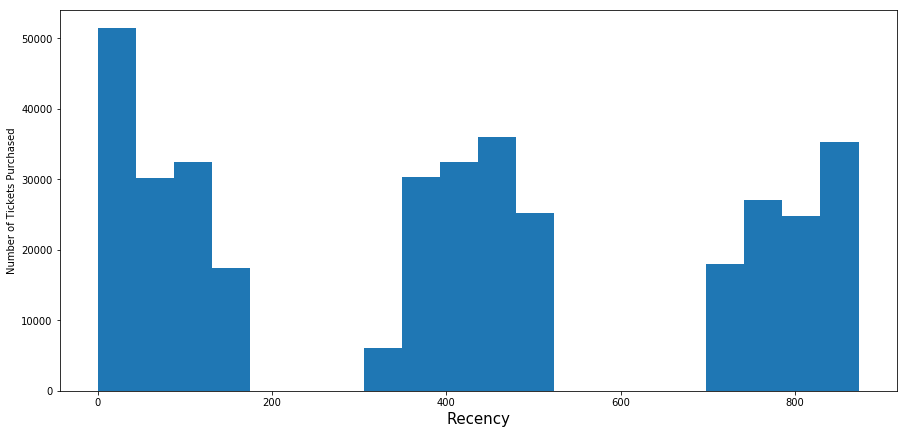

In [34]:
plt.figure(figsize=(15,7))
plt.hist(df_RFM['Recency'], bins=20)
plt.xlabel('Recency', size=15)
plt.ylabel('Number of Tickets Purchased')

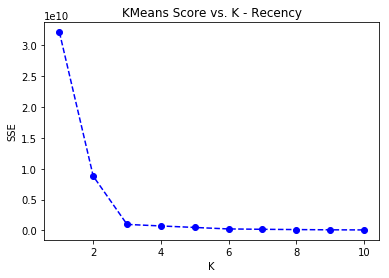

In [35]:
# test k values between 1 and 10
temp = []
cluster_numbers = list(range(1,11))

for center in cluster_numbers:
    temp.append(get_kmeans_score(df_RFM[['Recency']], center))
    
plt.plot(cluster_numbers, temp, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('KMeans Score vs. K - Recency');

In [36]:
#build 4 clusters for recency and add it to dataframe
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_RFM[['Recency']])
df_RFM['RecencyScore'] = kmeans.predict(df_RFM[['Recency']])

df_RFM = order_cluster('RecencyScore', 'Recency',df_RFM,False)

In [37]:
test=df_RFM.groupby('RecencyScore').agg({'acct_id': np.size,
                                        'Recency':np.mean}).rename(columns={'acct_id': 'Num_Customers',
                                                                            'Recency': 'Mean Recency'})
test

,Num_Customers,Mean Recency
RecencyScore,,
0,105273.0,799.300789
1,130032.0,432.630499
2,131452.0,70.648275


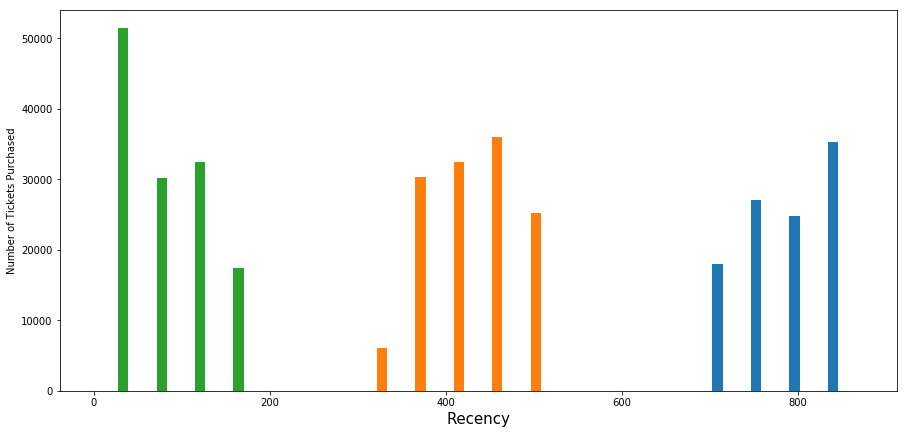

In [38]:
x_multi = [df_RFM[df_RFM['RecencyScore']==i]['Recency'] for i in [0,1,2]]
plt.figure(figsize=(15,7))

plt.hist(x_multi, bins=20)
plt.xlabel('Recency', size=15)
plt.ylabel('Number of Tickets Purchased')
plt.show()
#colored by recency cluster label

# Frequency

In [39]:
df_RFM['Frequency'].describe()

count    366757.000000
mean          4.530242
std          20.125149
min           1.000000
25%           2.000000
50%           3.000000
75%           5.000000
max       10690.000000
Name: Frequency, dtype: float64

In [40]:
# fig, ax = plt.subplots(figsize=(15,7))
# x = df_RFM['Frequency']
# binwidth = 10
# ax.hist(x, bins=range(min(x), max(x) + binwidth, binwidth))
# ax.set_xscale('log')
# plt.xlabel('Frequency', size=15)
# plt.ylabel('Number of Tickets Purchased')
# fig.show()

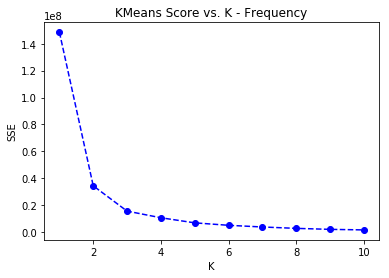

In [41]:
# test k values between 1 and 10
temp = []
cluster_numbers = list(range(1,11))

for center in tqdm_notebook(cluster_numbers):
    temp.append(get_kmeans_score(df_RFM[['Frequency']], center))
    
plt.plot(cluster_numbers, temp, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('KMeans Score vs. K - Frequency');

In [42]:
#build 5 clusters for frequency and add it to dataframe
kmeans = KMeans(n_clusters=5)
kmeans.fit(df_RFM[['Frequency']])
df_RFM['FrequencyCluster'] = kmeans.predict(df_RFM[['Frequency']])

df_RFM = order_cluster('FrequencyCluster', 'Frequency',df_RFM,False)

In [43]:
#Reverse the FrequencyScore by reversing the labels
df_RFM['FrequencyScore']=df_RFM['FrequencyCluster']

score_correction={0:4, 1:3, 2:2, 3:1, 4:0}   
for k,v in score_correction.items():
    df_RFM['FrequencyScore'].loc[df_RFM['FrequencyCluster']==k] = v
  

In [44]:
test=df_RFM.groupby('FrequencyScore').agg({'acct_id': np.size,
                                        'Frequency':np.mean}).rename(columns={'acct_id': 'Num_Customers',
                                                                            'Frequency': 'Mean Frequency'})
test

,Num_Customers,Mean Frequency
FrequencyScore,,
0,341857.0,3.482158
1,24837.0,17.485969
2,57.0,289.631579
3,5.0,1920.000000
4,1.0,10690.000000


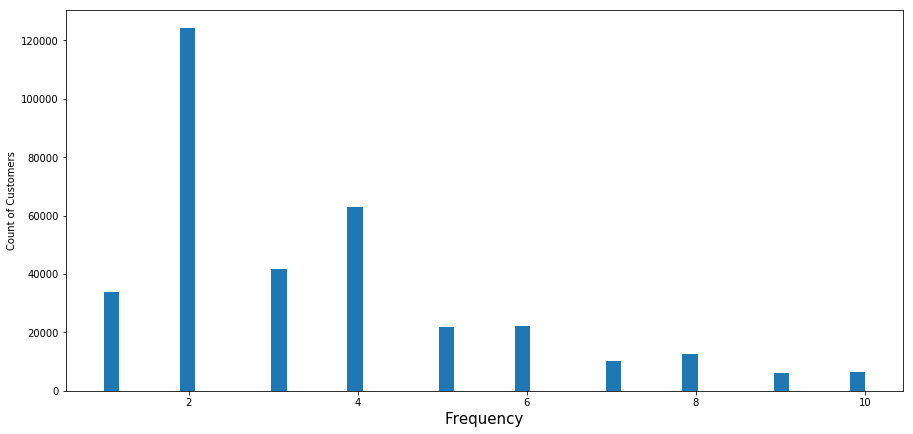

In [47]:
x_multi = [df_RFM[df_RFM['FrequencyScore']==i]['Frequency'] for i in [0,1,2,3,4]]
fig, ax = plt.subplots(figsize=(15,7))

ax.hist(x_multi[0], bins = 50)
# ax.set_xscale('log')
plt.xlabel('Frequency', size=15)
plt.ylabel('Count of Customers')
fig.show()

# Monetary

In [48]:
df_RFM['Monetary'].describe()

count    366757.000000
mean        198.798152
std         604.403678
min          19.000000
25%          76.000000
50%         130.000000
75%         258.000000
max      229700.000000
Name: Monetary, dtype: float64

In [49]:
# fig, ax = plt.subplots(figsize=(15,7))
# # x = df_RFM[df_RFM['Frequency']!=10690]['Frequency']
# x = df_RFM['Monetary']
# # binwidth = 10
# ax.hist(x, bins=50)
# ax.set_xscale('log')
# plt.xlabel('Monetary', size=15)
# plt.ylabel('Count of Customers')
# fig.show()

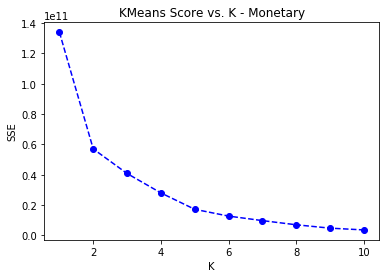

In [50]:
# test k values between 1 and 10
temp = []
cluster_numbers = list(range(1,11))

for center in tqdm_notebook(cluster_numbers):
    temp.append(get_kmeans_score(df_RFM[['Monetary']], center))
    
plt.plot(cluster_numbers, temp, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('KMeans Score vs. K - Monetary');

In [51]:
#build 5 clusters for monetary and add it to dataframe
kmeans = KMeans(n_clusters=5)
kmeans.fit(df_RFM[['Monetary']])
df_RFM['MonetaryCluster'] = kmeans.predict(df_RFM[['Monetary']])

df_RFM = order_cluster('MonetaryCluster', 'Monetary',df_RFM,False)

In [52]:
#Reverse the MonetaryScore by reversing the labels
df_RFM['MonetaryScore']=df_RFM['MonetaryCluster']

score_correction={0:4, 1:3, 2:2, 3:1, 4:0}   
for k,v in score_correction.items():
    df_RFM['MonetaryScore'].loc[df_RFM['MonetaryCluster']==k] = v
    

In [53]:
test=df_RFM.groupby('MonetaryScore').agg({'acct_id': np.size,
                                        'Monetary':np.mean}).rename(columns={'acct_id': 'Num_Customers',
                                                                            'Monetary': 'Mean Monetary'})
test

,Num_Customers,Mean Monetary
MonetaryScore,,
0,341482.0,147.186470
1,25205.0,835.606388
2,64.0,14168.156250
3,5.0,90232.600000
4,1.0,229700.000000


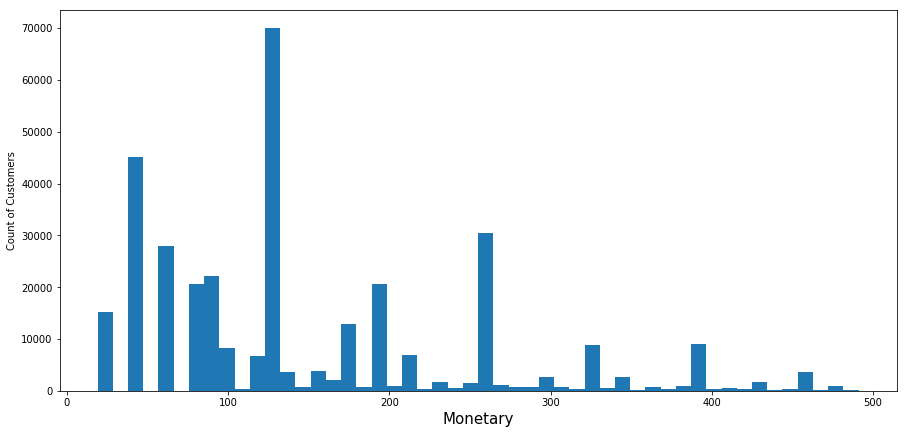

In [54]:
x_multi = [df_RFM[df_RFM['MonetaryScore']==i]['Monetary'] for i in [0,1,2,3,4]]
fig, ax = plt.subplots(figsize=(15,7))

ax.hist(x_multi[0], bins = 50)
# ax.set_xscale('log')
plt.xlabel('Monetary', size=15)
plt.ylabel('Count of Customers')
fig.show()

# Behavior

In [405]:
#create a datafframe of just the behavioral features
df_B=all_data_singleTicket[['acct_id',
                            'ticket_scanned',
                            'holiday',
                            'giveaway_item',
                            'event',
                            'day_night_code',
                            'series_nbr',
                            'game_date_dow',
                            'purchase_date_dow',
                            'purchase_on_winStreak',
                            'last_minute_buyer',
                            '30_day_buyer',
                            'section_500',
                            'section_200',
                            'section_100']]

In [406]:
#create column for ticket count
df_B['ticket_purchased']=1

In [407]:
#bin series_nbr into beginning, beginning-middle, middle, middle-end, and end of season
bins=[0,10,20, 30, 40, 52]
labels=['beg', 'beg-mid', 'mid', 'mid-end', 'end']
df_B['series_nbr_bins']=pd.cut(df_B['series_nbr'], bins=bins, labels=labels)

In [408]:
#convert categorical features to dummy features
df_B=pd.get_dummies(df_B, columns=['day_night_code', 'series_nbr_bins', 'purchase_date_dow', 'game_date_dow'])

In [409]:
#group by acct_id and sum the features
df_B_grouped=df_B.groupby(['acct_id']).sum()

In [410]:
df_B_grouped.head()

,ticket_scanned,holiday,giveaway_item,event,series_nbr,purchase_on_winStreak,last_minute_buyer,30_day_buyer,section_500,section_200,...,purchase_date_dow_4,purchase_date_dow_5,purchase_date_dow_6,game_date_dow_0,game_date_dow_1,game_date_dow_2,game_date_dow_3,game_date_dow_4,game_date_dow_5,game_date_dow_6
acct_id,,,,,,,,,,,,,,,,,,,,,
-1.0,36288.0,2946,11279,18023,1150957,619,23777,29394,18294,8315,...,7390.0,4274.0,4121.0,2839.0,3430.0,3724.0,4351.0,6998.0,9042.0,9421.0
0.0,321871.0,19089,86054,121352,9237773,27425,306645,313703,184585,58814,...,60255.0,58714.0,47504.0,28726.0,47509.0,45797.0,29457.0,60338.0,62512.0,55381.0
2.0,0.0,0,2,3,403,0,3,3,2,1,...,6.0,0.0,1.0,0.0,1.0,0.0,2.0,6.0,0.0,1.0
24.0,0.0,0,0,0,99,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
57.0,0.0,0,2,2,134,1,2,4,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0


In [411]:
#remove the -1 and 0 acct_id
df_B_grouped=df_B_grouped[(df_B_grouped.index!=-1) & (df_B_grouped.index!=0)]

In [412]:
#create a column for number of tickets and change ticket_scanned to %scanned
df_B_grouped['percent_tickets_scanned']=(df_B_grouped['ticket_scanned']/df_B_grouped['ticket_purchased']*100).astype(int)

In [413]:
#drop useless columns
df_B_grouped.drop(columns=['ticket_scanned',
                           'series_nbr'], inplace=True)

In [414]:
#scale features around mean
df_B_grouped_columns=df_B_grouped.columns
df_B_grouped_ss=p.StandardScaler().fit_transform(df_B_grouped)
df_B_grouped_ss=pd.DataFrame(df_B_grouped_ss, columns=df_B_grouped_columns)

In [415]:
df_B_grouped_ss.head()

,holiday,giveaway_item,event,purchase_on_winStreak,last_minute_buyer,30_day_buyer,section_500,section_200,section_100,ticket_purchased,...,purchase_date_dow_5,purchase_date_dow_6,game_date_dow_0,game_date_dow_1,game_date_dow_2,game_date_dow_3,game_date_dow_4,game_date_dow_5,game_date_dow_6,percent_tickets_scanned
0,-0.277347,0.059602,0.141647,-0.179603,0.112745,0.035606,0.017842,0.066926,0.770272,0.271788,...,-0.298506,0.273914,-0.180815,0.170571,-0.199381,0.236207,1.136089,-0.222140,0.017630,-4.271534
1,-0.277347,-0.175345,-0.173723,-0.179603,-0.216456,-0.238746,-0.095292,-0.318194,0.151649,-0.076036,...,-0.298506,-0.273847,-0.180815,-0.167520,-0.199381,-0.074495,-0.166314,-0.222140,0.584882,-4.271534
2,-0.277347,0.059602,0.036523,0.863482,0.003011,0.127056,-0.095292,-0.318194,0.306305,-0.026347,...,-0.298506,-0.273847,-0.180815,-0.167520,-0.199381,0.080856,0.484887,-0.222140,-0.265996,-4.271534
3,-0.277347,0.529497,0.457017,-0.179603,-0.216456,-0.238746,-0.095292,-0.318194,2.935451,0.818368,...,-0.298506,-0.273847,-0.180815,1.861027,2.260853,0.391558,-0.166314,-0.222140,1.435760,-0.612691
4,-0.277347,-0.175345,0.141647,-0.179603,-0.216456,-0.238746,-0.095292,-0.318194,0.151649,-0.076036,...,-0.298506,-0.273847,-0.180815,-0.167520,-0.199381,-0.074495,-0.166314,0.401635,-0.265996,0.302020


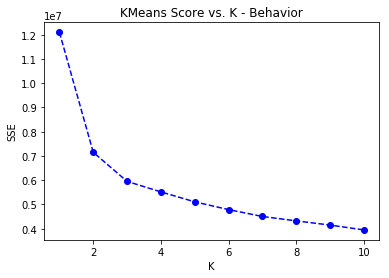

In [416]:
# test k values between 1 and 10
temp = []
cluster_numbers = list(range(1,11))

for center in tqdm_notebook(cluster_numbers):
    temp.append(get_kmeans_score(df_B_grouped_ss, center))
    
plt.plot(cluster_numbers, temp, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('KMeans Score vs. K - Behavior');

In [417]:
#build 4 clusters for behavior and add it to dataframe
kmeans = KMeans(n_clusters=4)
model_behavior = kmeans.fit(df_B_grouped_ss)
labels_behavior = model_behavior.predict(df_B_grouped_ss)

#append cluster label to orginal dataframe
df_B_grouped['BehaviorCluster']=labels_behavior

In [418]:
df_B_grouped.reset_index(drop=False, inplace=True)

In [419]:
df_B_grouped.head()

,acct_id,holiday,giveaway_item,event,purchase_on_winStreak,last_minute_buyer,30_day_buyer,section_500,section_200,section_100,...,purchase_date_dow_6,game_date_dow_0,game_date_dow_1,game_date_dow_2,game_date_dow_3,game_date_dow_4,game_date_dow_5,game_date_dow_6,percent_tickets_scanned,BehaviorCluster
0,2.0,0,2,3,0,3,3,2,1,7,...,1.0,0.0,1.0,0.0,2.0,6.0,0.0,1.0,0,2
1,24.0,0,0,0,0,0,0,0,0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0,2
2,57.0,0,2,2,1,2,4,0,0,4,...,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0,2
3,75.0,0,6,6,0,0,0,0,0,21,...,0.0,0.0,6.0,6.0,3.0,0.0,0.0,6.0,80,0
4,82.0,0,0,3,0,0,0,0,0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,100,2


# RFM ANALYSIS

In [429]:
df_RFM=df_RFM[['acct_id', 'Frequency', 'Recency', 'Monetary', 'RecencyScore', 'FrequencyScore', 'MonetaryScore']]

In [430]:
df_RFM['RFM_Score']=df_RFM['RecencyScore']+df_RFM['FrequencyScore']+df_RFM['MonetaryScore']

In [431]:
RFM_scoreSum=df_RFM.groupby('RFM_Score')['Recency', 'Frequency', 'Monetary'].mean()

In [433]:
RFM_scoreSum['Segment'] = 'Low-Value'
RFM_scoreSum.loc[RFM_scoreSum.index>1,'Segment'] = 'Mid-Value' 
RFM_scoreSum.loc[RFM_scoreSum.index>5,'Segment'] = 'High-Value' 

RFM_scoreSum.reset_index(drop=False, inplace=True)
RFM_scoreSum_formerge=RFM_scoreSum[['RFM_Score', 'Segment']]
RFM_scoreSum

,RFM_Score,Recency,Frequency,Monetary,Segment
0,0,800.774688,3.140363,136.576982,Low-Value
1,1,445.630091,3.553858,152.284791,Low-Value
2,2,106.221283,4.022685,171.264094,Mid-Value
3,3,216.747090,13.650909,595.291312,Mid-Value
4,4,62.491895,19.686126,998.723023,Mid-Value
5,5,46.318182,167.227273,8497.409091,Mid-Value
6,6,24.342105,345.526316,18483.263158,High-Value
7,7,13.000000,1662.000000,31578.000000,High-Value
8,8,47.750000,1984.500000,96466.000000,High-Value
9,10,0.000000,10690.000000,229700.000000,High-Value


In [434]:
print(df_B_grouped.shape)
print(df_RFM.shape)

test=pd.merge(df_B_grouped, df_RFM, on='acct_id', how='left')
test=pd.merge(test, RFM_scoreSum_formerge, on='RFM_Score', how='left')
print(test.shape)

(366757, 35)
(366757, 8)
(366757, 43)


In [436]:
agg_dict={'acct_id': np.size,
          'holiday': np.sum,
          'giveaway_item': np.sum,
          'event': np.sum,
          'purchase_on_winStreak': np.sum,
          'last_minute_buyer': np.sum,
          '30_day_buyer': np.sum,
          'section_500': np.sum,
          'section_200': np.sum,
          'section_100': np.sum,
          'day_night_code_A': np.sum,
          'day_night_code_D': np.sum,
          'day_night_code_E': np.sum,
          'series_nbr_bins_beg': np.sum,
          'series_nbr_bins_beg-mid': np.sum,
          'series_nbr_bins_mid': np.sum,
          'series_nbr_bins_mid-end': np.sum,
          'series_nbr_bins_end': np.sum,
          'game_date_dow_0': np.sum,
          'game_date_dow_1': np.sum,
          'game_date_dow_2': np.sum,
          'game_date_dow_3': np.sum,
          'game_date_dow_4': np.sum,
          'game_date_dow_5': np.sum,
          'game_date_dow_6': np.sum,
          'ticket_purchased': np.sum}

column_names={'acct_id':'Num_customers', 'ticket_purchased': 'total_tickets'}
    
test2=test.groupby(['Segment']).agg(agg_dict).rename(columns=column_names)


In [437]:
test2

,Num_customers,holiday,giveaway_item,event,purchase_on_winStreak,last_minute_buyer,30_day_buyer,section_500,section_200,section_100,...,series_nbr_bins_mid-end,series_nbr_bins_end,game_date_dow_0,game_date_dow_1,game_date_dow_2,game_date_dow_3,game_date_dow_4,game_date_dow_5,game_date_dow_6,total_tickets
Segment,,,,,,,,,,,,,,,,,,,,,
High-Value,44.0,1019,14600,12295,442,12897,16376,16596,2699,14125,...,9474.0,6522.0,1504.0,3779.0,2836.0,9765.0,5155.0,6112.0,4269.0,33420
Low-Value,219868.0,78071,239682,259839,41416,317916,428185,290279,129717,320642,...,160869.0,143128.0,43376.0,85524.0,84384.0,71754.0,126321.0,170727.0,158552.0,740638
Mid-Value,146845.0,81875,293152,333956,21292,392636,512916,310957,170606,405877,...,212239.0,119477.0,63894.0,92421.0,91115.0,94350.0,149529.0,214992.0,181139.0,887440


## Behavioral vs. RFM

In [438]:
#make every feature a percent of ticket_purchased
columns_to_adjust=test2.columns
columns_to_adjust = [e for e in columns_to_adjust if e not in ('Num_customers', 'total_tickets')]
columns_to_adjust

for column in columns_to_adjust:
    test2[column]=(test2[column]/test2['total_tickets']*100).round().astype(int)

test2

,Num_customers,holiday,giveaway_item,event,purchase_on_winStreak,last_minute_buyer,30_day_buyer,section_500,section_200,section_100,...,series_nbr_bins_mid-end,series_nbr_bins_end,game_date_dow_0,game_date_dow_1,game_date_dow_2,game_date_dow_3,game_date_dow_4,game_date_dow_5,game_date_dow_6,total_tickets
Segment,,,,,,,,,,,,,,,,,,,,,
High-Value,44.0,3,44,37,1,39,49,50,8,42,...,28,20,5,11,8,29,15,18,13,33420
Low-Value,219868.0,11,32,35,6,43,58,39,18,43,...,22,19,6,12,11,10,17,23,21,740638
Mid-Value,146845.0,9,33,38,2,44,58,35,19,46,...,24,13,7,10,10,11,17,24,20,887440


In [439]:
test2_woHigh=test2[test2.index!='High-Value']
test2_woHigh.head()

,Num_customers,holiday,giveaway_item,event,purchase_on_winStreak,last_minute_buyer,30_day_buyer,section_500,section_200,section_100,...,series_nbr_bins_mid-end,series_nbr_bins_end,game_date_dow_0,game_date_dow_1,game_date_dow_2,game_date_dow_3,game_date_dow_4,game_date_dow_5,game_date_dow_6,total_tickets
Segment,,,,,,,,,,,,,,,,,,,,,
Low-Value,219868.0,11,32,35,6,43,58,39,18,43,...,22,19,6,12,11,10,17,23,21,740638
Mid-Value,146845.0,9,33,38,2,44,58,35,19,46,...,24,13,7,10,10,11,17,24,20,887440


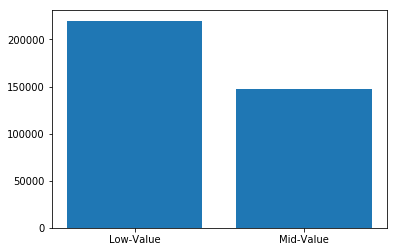

In [440]:
#Number of Customers by RFM Score
plt.bar(test2_woHigh.index, test2_woHigh['Num_customers'])
plt.show()

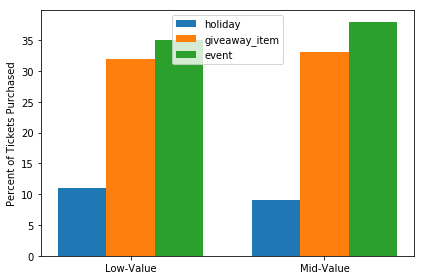

In [441]:
labels = test2_woHigh.index
y1 = test2_woHigh['holiday']
y2 = test2_woHigh['giveaway_item']
y3 = test2_woHigh['event']

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, y1, width, label='holiday')
rects2 = ax.bar(x , y2, width, label='giveaway_item')
rects3 = ax.bar(x + width, y3, width, label='event')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percent of Tickets Purchased')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

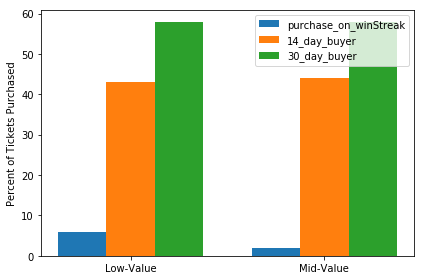

In [442]:
labels = test2_woHigh.index
y1 = test2_woHigh['purchase_on_winStreak']
y2 = test2_woHigh['last_minute_buyer']
y3 = test2_woHigh['30_day_buyer']

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, y1, width, label='purchase_on_winStreak')
rects2 = ax.bar(x , y2, width, label='14_day_buyer')
rects3 = ax.bar(x +width, y3, width, label='30_day_buyer')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percent of Tickets Purchased')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


fig.tight_layout()

plt.show()

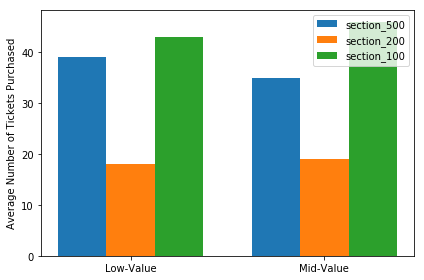

In [443]:
labels = test2_woHigh.index
y1 = test2_woHigh['section_500']
y2 = test2_woHigh['section_200']
y3 = test2_woHigh['section_100']

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, y1, width, label='section_500')
rects2 = ax.bar(x , y2, width, label='section_200')
rects3 = ax.bar(x + width, y3, width, label='section_100')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Average Number of Tickets Purchased')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
fig.tight_layout()

plt.show()

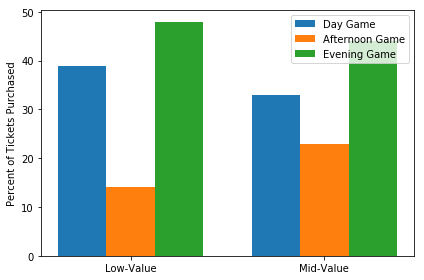

In [444]:
labels = test2_woHigh.index
y1 = test2_woHigh['day_night_code_D']
y2 = test2_woHigh['day_night_code_A']
y3 = test2_woHigh['day_night_code_E']

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, y1, width, label='Day Game')
rects2 = ax.bar(x , y2, width, label='Afternoon Game')
rects3 = ax.bar(x + width, y3, width, label='Evening Game')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percent of Tickets Purchased')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


fig.tight_layout()

plt.show()

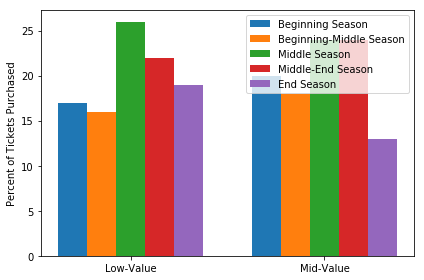

In [445]:
labels = test2_woHigh.index
y1 = test2_woHigh['series_nbr_bins_beg']
y2 = test2_woHigh['series_nbr_bins_beg-mid']
y3 = test2_woHigh['series_nbr_bins_mid']
y4 = test2_woHigh['series_nbr_bins_mid-end']
y5 = test2_woHigh['series_nbr_bins_end']

x = np.arange(len(labels))  # the label locations
width = 0.15 # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - 2*width, y1, width, label='Beginning Season')
rects2 = ax.bar(x - width, y2, width, label='Beginning-Middle Season')
rects3 = ax.bar(x , y3, width, label='Middle Season')
rects3 = ax.bar(x + width, y4, width, label='Middle-End Season')
rects3 = ax.bar(x + 2*width, y5, width, label='End Season')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percent of Tickets Purchased')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()


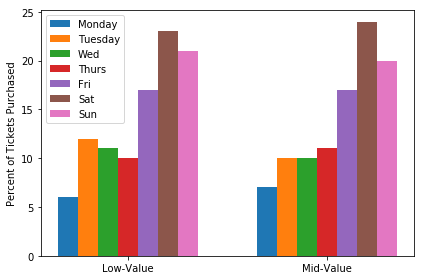

In [446]:
labels = test2_woHigh.index
y0 = test2_woHigh['game_date_dow_0']
y1 = test2_woHigh['game_date_dow_1']
y2 = test2_woHigh['game_date_dow_2']
y3 = test2_woHigh['game_date_dow_3']
y4 = test2_woHigh['game_date_dow_4']
y5 = test2_woHigh['game_date_dow_5']
y6 = test2_woHigh['game_date_dow_6']

x = np.arange(len(labels))  # the label locations
width = 0.1 # the width of the bars

fig, ax = plt.subplots()
rects0 = ax.bar(x - 3*width, y0, width, label='Monday')
rects1 = ax.bar(x - 2*width, y1, width, label='Tuesday')
rects2 = ax.bar(x - width, y2, width, label='Wed')
rects3 = ax.bar(x , y3, width, label='Thurs')
rects4 = ax.bar(x + width, y4, width, label='Fri')
rects5 = ax.bar(x + 2*width, y5, width, label='Sat')
rects6 = ax.bar(x + 3*width, y6, width, label='Sun')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percent of Tickets Purchased')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()